In [1]:
%matplotlib inline

In [2]:
import numpy as np
import kali.carma
import kali
import gatspy
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [14,8]
from lsstlc import * # derived LSST lightcurve sub-class

/home/kali/python/kali/lc.py:29: UserWarning: No display environment! Using matplotlib backend "Agg"
  warnings.warn('No display environment! Using matplotlib backend "Agg"')
/home/conda/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Load MAF output

In [3]:
# load MAF output from file, which was saved from the obs_hist notebook
maf = np.load('/home/mount/MAF output/58_-27_poster.npz') 

# get the result for minion_1016, baseline cadence
bl_meta = maf['meta1'] # [ra, dec, min_gap, opsim_id], min_gap in hours
bl_cadence = maf['cadence1'] # cadence in structured array

# result for baseline with no pairs
# bl_np_meta = maf['meta2']
# bl_np_cadence = maf['cadence2']

#rolling cadence
roll_meta = maf['meta3']
roll_cadence = maf['cadence3']

In [4]:
# determine lowest seperation between three different cadence
sep = np.array([float(bl_meta[2]), float(roll_meta[2])])
min_sep = np.min(sep)

## CARMA (2,1)

In [6]:
# Initiate carma task
Task = kali.carma.CARMATask(2,1,nsteps = 500)

In [8]:
# declare input timescales and amplitude, organize in an array
r_1 = (-1.0/107.8) + 0j
r_2 = (-1.0/33.2) + 0j
m_1 = (-1.0/5.5) + 0j
amp = 1.0

Rho = np.array([r_1, r_2, m_1, amp]) # put the selected paramenters into array format
Theta = kali.carma.coeffs(2, 1, Rho) # use the array of roots above to solve for coefficients
print Theta # print out the calculated coefficients
print Task.check(Theta) # check whether computed coefficients make sense, if True then OK

[ 0.03939692  0.00027941  0.0046724   0.0256982 ]
True


In [9]:
dt = min_sep/24 # convert min_gap from hours to days, Kali uses days
Task.set(dt, Theta) # Will print 0 if parameters set successfuly

0

### Simulate DHO lc

In [10]:
dho_lc = Task.simulate(duration=3650)

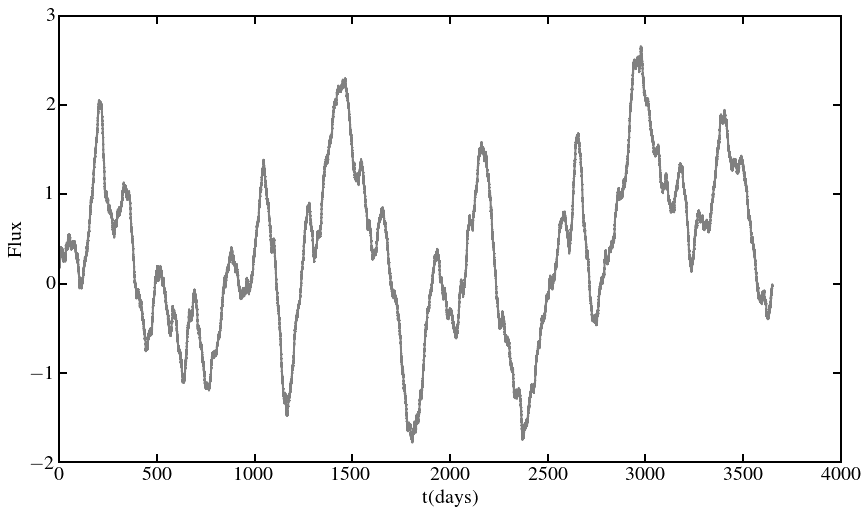

In [11]:
# plot simulated lightcurve
f = plt.figure()
plt.ylabel('Flux')
plt.xlabel('t(days)')
plt.plot(dho_lc.t, dho_lc.x, color='gray') # x is the variation about the mean flux

### Add noise (SNR 100)

In [12]:
dho_lc.fracNoiseToSignal = 0.01
Task.observe(dho_lc)

### Save lc to file

In [13]:
lc2file('/home/mount/c21_58_-27_lc', dho_lc)

### From lc file

In [5]:
dho_lc = extLC('/home/mount/c21_58_-27_lc.npz')

## Downsample LC

#### Baseline (minion_1016)

In [6]:
bl_down = lsstlc(bl_meta[0], bl_meta[1], bl_cadence['expDate'], dho_lc, float(min_sep))

In [7]:
# For Rachael:
import pandas as pd

df = pd.DataFrame.from_records(bl_cadence[:-1])
df['obsTimes (days)'] = bl_down.t
df['absFlux'] = bl_down.y
df['fluxErr'] = bl_down.yerr

df.to_csv('/home/mount/lsst_cadence/Rachael/wfd_dho.csv', index=False)

#### Rolling (enigma_1260)

In [15]:
roll_down = lsstlc(bl_meta[0], bl_meta[1], roll_cadence['expDate'], dho_lc, float(min_sep))

## Fit down-sampled lc to DHO

In [17]:
Task.clear()
Task.fit(bl_down)
print 'Baseline cadence (WFD+DDF), minion_1016'
print ' Input parameters: \n {}'.format([107.8, 33.2, 5.5, 1])
print ' Best-fit paremeters:\n {}'.format(Task.bestTau)

Baseline cadence (WFD+DDF), minion_1016
 Input parameters: 
 [107.8, 33.2, 5.5, 1]
 Best-fit paremeters:
 [  58.31935567  783.82386205    5.31388415    0.95534057]


In [18]:
Task.clear()
Task.fit(roll_down)
print 'Rolling cadence, enigma_1260'
print ' Input parameters: \n {}'.format([107.8, 33.2, 5.5, 1])
print ' Best-fit paremeters:\n {}'.format(Task.bestTau)

Rolling cadence, enigma_1260
 Input parameters: 
 [107.8, 33.2, 5.5, 1]
 Best-fit paremeters:
 [  5.55568882e+01   1.33370174e+03   5.31325760e+00   9.33198360e-01]
